In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dataset = pd.read_csv('AirPassengers.csv')

#parse strings to datetime type
dataset['Month'] = pd.to_datetime(dataset['Month'], infer_datetime_format = True)
indexedDataset = dataset.set_index(['Month'])

In [3]:
from datetime import datetime
indexedDataset.head(5)

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Text(0, 0.5, 'No. of Passengers')

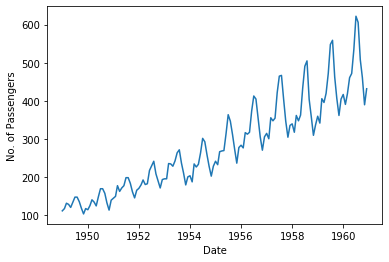

In [4]:
plt.plot(indexedDataset)
plt.xlabel('Date')
plt.ylabel('No. of Passengers')

Here, we have an upward trend and the mean is not constant.

### Determining Rolling Statistics

In [5]:
#window = 12 will give rolling mean at yearly level
rolmean = indexedDataset.rolling(window = 12).mean()

rolstd = indexedDataset.rolling(window = 12).std()
print(rolmean,rolstd)

            #Passengers
Month                  
1949-01-01          NaN
1949-02-01          NaN
1949-03-01          NaN
1949-04-01          NaN
1949-05-01          NaN
...                 ...
1960-08-01   463.333333
1960-09-01   467.083333
1960-10-01   471.583333
1960-11-01   473.916667
1960-12-01   476.166667

[144 rows x 1 columns]             #Passengers
Month                  
1949-01-01          NaN
1949-02-01          NaN
1949-03-01          NaN
1949-04-01          NaN
1949-05-01          NaN
...                 ...
1960-08-01    83.630500
1960-09-01    84.617276
1960-10-01    82.541954
1960-11-01    79.502382
1960-12-01    77.737125

[144 rows x 1 columns]


**Plot the Rolling Statistics**

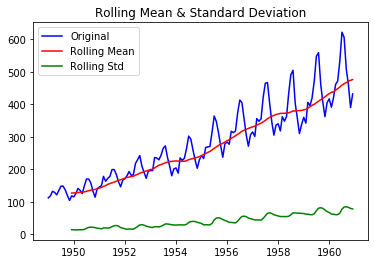

In [6]:
orig = plt.plot(indexedDataset , color = 'blue' , label = 'Original')
mean = plt.plot(rolmean , color = 'red' , label = 'Rolling Mean')
std = plt.plot(rolstd , color = 'green' , label = 'Rolling Std')

plt.legend(loc = 'best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

Conclusion: Mean and Std is not constant.

## Perform Dickey-Fuller Test:

In [7]:
from statsmodels.tsa.stattools import adfuller

print('Results of Dickey-Fuller Test:')

dftest = adfuller(indexedDataset['#Passengers'], autolag = 'AIC')
dftest

Results of Dickey-Fuller Test:


(0.8153688792060543,
 0.9918802434376411,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)

In [8]:

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used',
                                         'No of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic               0.815369
p-value                      0.991880
#Lags Used                  13.000000
No of Observations Used    130.000000
Critical Value (1%)         -3.481682
Critical Value (5%)         -2.884042
Critical Value (10%)        -2.578770
dtype: float64

Since p-value is > 0.5 i.e, 0.9 we cannot reject null hypothesis. Means the data is not stationary. <br>
Also Critical Values should always be greater than Test Statistic.

**So we will Estimate the trend**

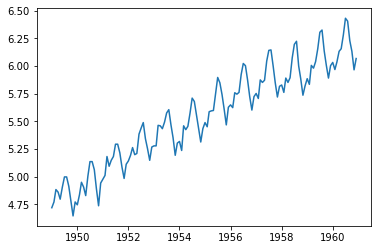

In [9]:
indexedDataset_logScale = np.log(indexedDataset)
plt.plot(indexedDataset_logScale)

In [33]:
type(indexedDataset_logScale)

pandas.core.frame.DataFrame

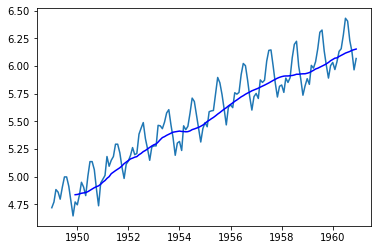

In [10]:
#Let's calculate the rolling statistics again
moving_mean = indexedDataset_logScale.rolling(window = 12).mean()
moving_std = indexedDataset_logScale.rolling(window = 12).std()

plt.plot(indexedDataset_logScale)
plt.plot(moving_mean, color = 'Blue')

Again its not stationary since mean is not constant.

### Lets transform the dataset to make it stationary

In [11]:
dataset_log_minus_moving_avg = indexedDataset_logScale - moving_mean
dataset_log_minus_moving_avg.head(15)

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN
1949-06-01,NaN
1949-07-01,NaN
1949-08-01,NaN
1949-09-01,NaN


In [12]:
dataset_log_minus_moving_avg.dropna(inplace = True)
dataset_log_minus_moving_avg.head(5)

,#Passengers
Month,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142


**Function to check stationarity**

In [13]:
def test_stationarity(timeSeries):
    
    #Determine Rolling Statistics
    moving_avg = timeSeries.rolling(window = 12).mean()
    moving_std = timeSeries.rolling(window = 12).std()
    
    #Plot Rolling Statistics
    plt.figure(figsize = (10,5))
    plt.plot(timeSeries, color = 'blue', label='Original')
    plt.plot(moving_avg,color = 'red', label= 'Moving Average')
    plt.plot(moving_std, color = 'black', label= 'Moving Std')
    plt.title('Rolling Statistics')
    plt.legend(loc = 'best')
    plt.show()
    
    
    #Perform Dickey Fuller Test
    print('Results of Dickey-Fuller Test:')
    dtest = adfuller(timeSeries['#Passengers'] , autolag = 'AIC')
    dtest_output = pd.Series(dtest[0:4], index = ['Test Statistic', 'p-value','#lags used','#observations used'])
    for key,values in dtest[4].items():
        dtest_output['Critical Value (%s)'%key] = value
    print(dtest_output)

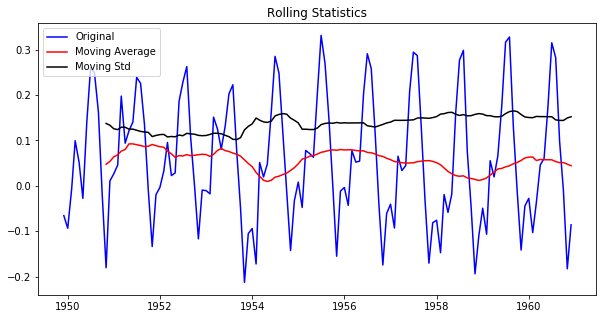

Results of Dickey-Fuller Test:
Test Statistic           -3.162908
p-value                   0.022235
#lags used               13.000000
#observations used      119.000000
Critical Value (1%)      -2.578770
Critical Value (5%)      -2.578770
Critical Value (10%)     -2.578770
dtype: float64


In [14]:
test_stationarity(dataset_log_minus_moving_avg)

**Observations:** <br>
p-value is less than 0.5 means we can reject null hypothesis(i.e, its not stationary). <br>
Critival values are also greater than T statistic. <br>

**Calculating Weighted Average** <br>
To see the trend present in our time series

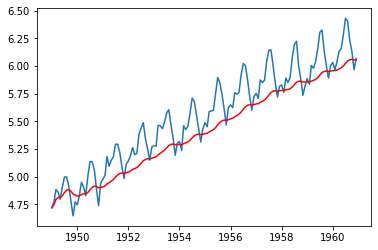

In [15]:
exponentialDecayedWeightedAverage = indexedDataset_logScale.ewm(halflife =12, min_periods =0, adjust =True).mean()
plt.plot(indexedDataset_logScale)
plt.plot(exponentialDecayedWeightedAverage, color = 'red')

### Transformation: ( log dataset - exponential weighted avg)

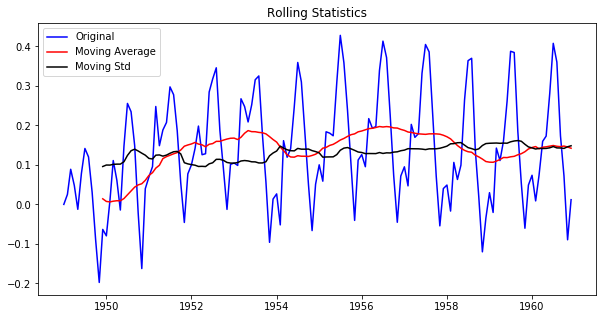

Results of Dickey-Fuller Test:
Test Statistic           -3.601262
p-value                   0.005737
#lags used               13.000000
#observations used      130.000000
Critical Value (1%)      -2.578770
Critical Value (5%)      -2.578770
Critical Value (10%)     -2.578770
dtype: float64


In [16]:
datasetlogminusweightedavg = indexedDataset_logScale - exponentialDecayedWeightedAverage
test_stationarity(datasetlogminusweightedavg)

### Now that our data is stationary we'll shift it into time series, so that we can use it for forecasting.

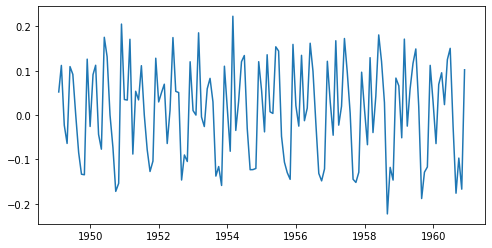

In [17]:
#differentiation is being done here
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift()
plt.figure(figsize = (8,4))
plt.plot(datasetLogDiffShifting)

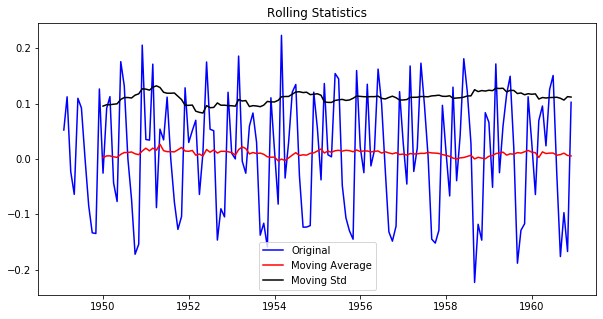

Results of Dickey-Fuller Test:
Test Statistic           -2.717131
p-value                   0.071121
#lags used               14.000000
#observations used      128.000000
Critical Value (1%)      -2.578770
Critical Value (5%)      -2.578770
Critical Value (10%)     -2.578770
dtype: float64


In [18]:
datasetLogDiffShifting.dropna(inplace = True)
test_stationarity(datasetLogDiffShifting)

## Components of Time Series

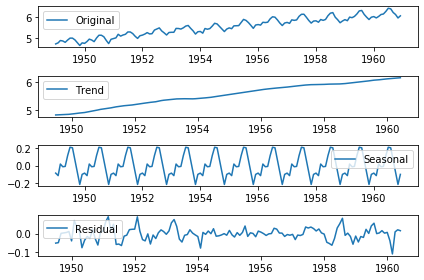

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(indexedDataset_logScale)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(indexedDataset_logScale, label = 'Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label = 'Seasonal')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label = 'Residual')
plt.legend(loc='best')

plt.tight_layout()

In [20]:
temp = pd.DataFrame(residual)
temp.columns = ['#Passengers']

In [21]:
temp.head()

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN


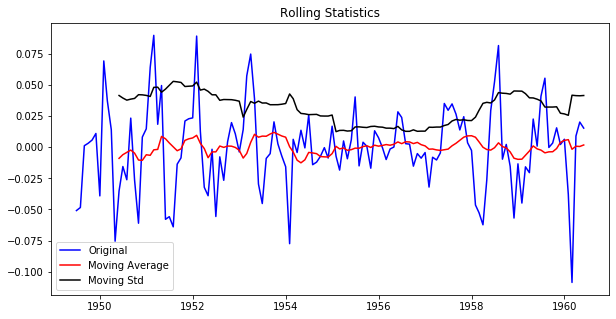

Results of Dickey-Fuller Test:
Test Statistic         -6.332387e+00
p-value                 2.885059e-08
#lags used              9.000000e+00
#observations used      1.220000e+02
Critical Value (1%)    -2.578770e+00
Critical Value (5%)    -2.578770e+00
Critical Value (10%)   -2.578770e+00
dtype: float64


In [22]:
temp.dropna(inplace = True)
test_stationarity(temp)

**Now lets calculate the value of P and Q using PACF and ACF graphs.**

C:\Users\kanha\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


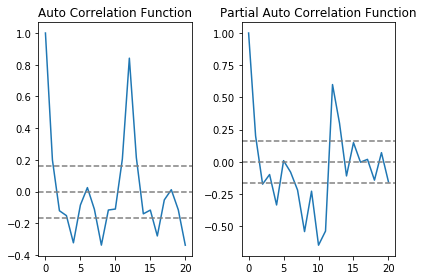

In [23]:
from statsmodels.tsa.stattools import pacf,acf
lag_acf = acf(datasetLogDiffShifting, nlags = 20)
lag_pacf = pacf(datasetLogDiffShifting, nlags = 20, method = 'ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color = 'gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle = '--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle = '--', color='gray')
plt.title('Auto Correlation Function')


#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color = 'gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle = '--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle = '--', color='gray')
plt.title('Partial Auto Correlation Function')

plt.tight_layout()

Check where the graph cuts with 0, to find values of P and Q. <br>
So we've obtained P=2, Q=2.

The value of D = 1, since we have differentiated it once.<br>
Now lets use these values in the ARIMA model.

Plotting AR model


C:\Users\kanha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kanha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


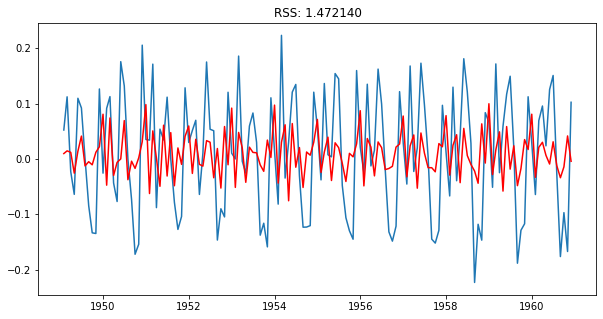

In [24]:
from statsmodels.tsa.arima_model import ARIMA

#AR model
model = ARIMA(indexedDataset_logScale, order = (0,1,2))
results_AR = model.fit(disp = -1)
plt.figure(figsize=(10,5))
plt.plot(datasetLogDiffShifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %4f'%sum((results_AR.fittedvalues- datasetLogDiffShifting['#Passengers'])**2))
print('Plotting AR model')

Greater the RSS score, the bad it is for you. Play around with the parameters to find lowest RSS score.

Plotting MA model


C:\Users\kanha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kanha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


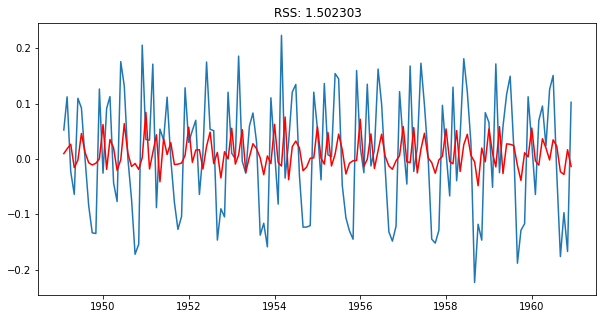

In [25]:
#MA model
model = ARIMA(indexedDataset_logScale, order = (2,1,0))
results_MA = model.fit(disp = -1)
plt.figure(figsize=(10,5))
plt.plot(datasetLogDiffShifting)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %4f'%sum((results_MA.fittedvalues- datasetLogDiffShifting['#Passengers'])**2))
print('Plotting MA model')

**Let's combine both and plot ARIMA**

C:\Users\kanha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kanha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Plotting ARIMA model


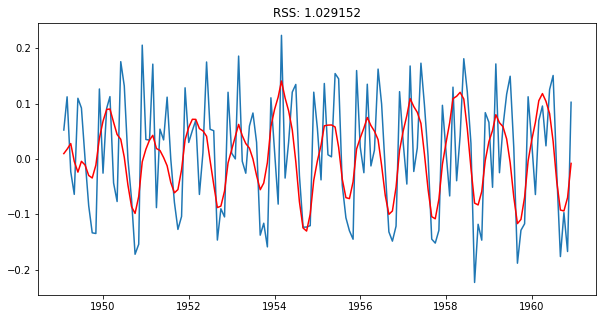

In [26]:
model = ARIMA(indexedDataset_logScale, order = (2,1,2))
results_ARIMA = model.fit(disp = -1)
plt.figure(figsize=(10,5))
plt.plot(datasetLogDiffShifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %4f'%sum((results_ARIMA.fittedvalues- datasetLogDiffShifting['#Passengers'])**2))
print('Plotting ARIMA model')

In [27]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64


In [28]:
#convert to cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64


In [34]:
predictions_ARIMA_diff_cumsum = pd.DataFrame(predictions_ARIMA_diff_cumsum, columns = ['#Passengers'])
predictions_ARIMA_diff_cumsum.head()

,#Passengers
Month,
1949-02-01,0.009580
1949-03-01,0.027071
1949-04-01,0.054742
1949-05-01,0.050221
1949-06-01,0.026331


In [44]:
indexedDataset_logScale.head()

,#Passengers
Month,
1949-01-01,4.718499
1949-02-01,4.770685
1949-03-01,4.882802
1949-04-01,4.859812
1949-05-01,4.795791


In [43]:
predictions_ARIMA_log = predictions_ARIMA_diff_cumsum.add(indexedDataset_logScale,
                                                          fill_value = 0)
predictions_ARIMA_log.head()

,#Passengers
Month,
1949-01-01,4.718499
1949-02-01,4.780265
1949-03-01,4.909873
1949-04-01,4.914554
1949-05-01,4.846011


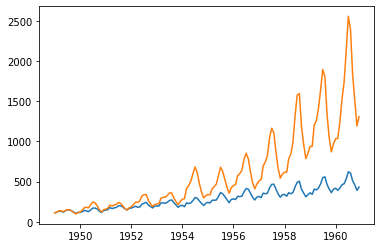

In [45]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(indexedDataset)
plt.plot(predictions_ARIMA)

In [46]:
indexedDataset_logScale

,#Passengers
Month,
1949-01-01,4.718499
1949-02-01,4.770685
1949-03-01,4.882802
1949-04-01,4.859812
1949-05-01,4.795791
...,...
1960-08-01,6.406880
1960-09-01,6.230481
1960-10-01,6.133398


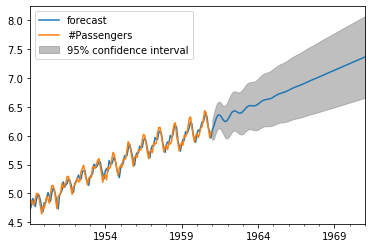

In [49]:
results_ARIMA.plot_predict(1,264)
x = results_ARIMA.forecast(steps = 120)  #120 because we're predicting for next 10 years
                                         #10*12=120
